In [43]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import networkx as nx


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [44]:
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip"
data_dir = keras.utils.get_file(origin=url, extract=True, archive_format="zip")
data_dir = data_dir.rstrip("PeMSD7_Full.zip")

route_distances = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_W_1026.csv"), header=None
).to_numpy()
speeds_array = pd.read_csv(os.path.join(data_dir, "PeMSD7_V_1026.csv"), header=None).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(1026, 1026)
speeds_array shape=(12672, 1026)


In [45]:
np.random.seed(42)

# Define the number of sample routes to select
num_sample_routes = 100

# Generate random indices for selecting sample routes
sample_routes = np.random.choice(route_distances.shape[0], num_sample_routes, replace=False)
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(100, 100)
speeds_array shape=(12672, 100)


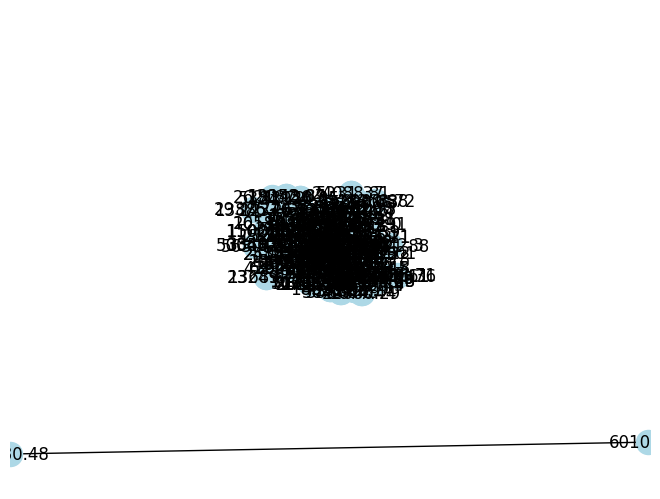

In [46]:
G = nx.Graph()

for row in route_distances:
    source, destination, distance = row[0], row[1], row[2]

    G.add_node(source)
    G.add_node(destination)

    G.add_edge(source, destination, weight=distance)

pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

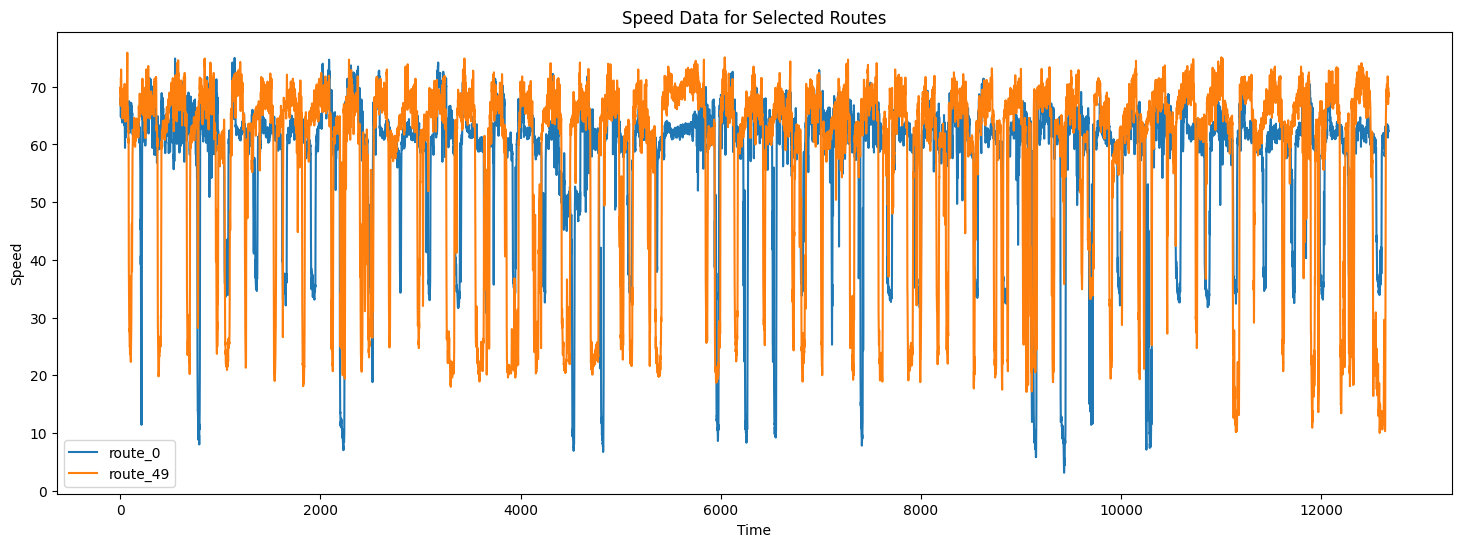

In [47]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_49"])
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed Data for Selected Routes")
plt.show()

Text(0, 0.5, 'road number')

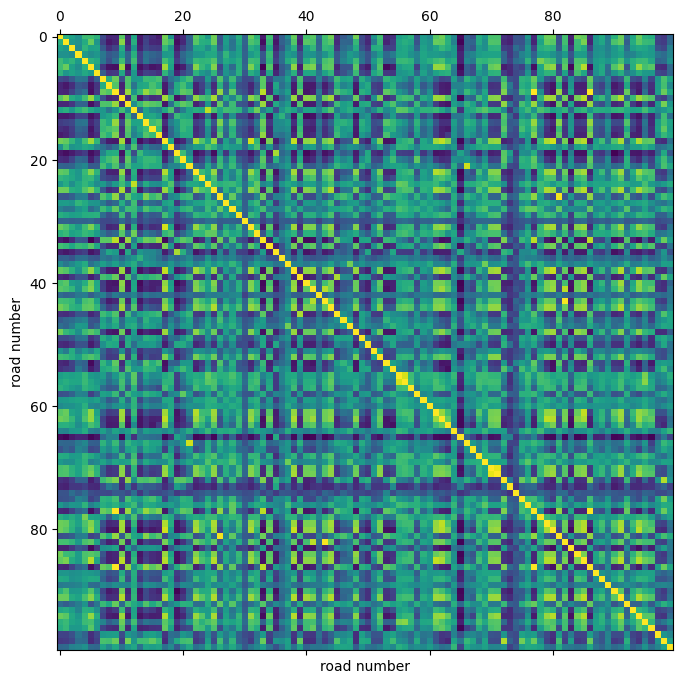

In [48]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")

In [49]:
import numpy as np

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """
    Preprocesses the input data array into training, validation, and test sets.

    Parameters:
    data_array (np.ndarray): Input data array.
    train_size (float): Size of the training set (between 0 and 1).
    val_size (float): Size of the validation set (between 0 and 1).

    Returns:
    np.ndarray, np.ndarray, np.ndarray: Tuple containing the preprocessed training,
    validation, and test sets.
    """
    assert isinstance(data_array, np.ndarray), "Input data_array must be a NumPy array"
    assert 0 < train_size < 1, "train_size must be between 0 and 1"
    assert 0 < val_size < 1, "val_size must be between 0 and 1"

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array

train_size, val_size = 0.5, 0.30
train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")


train set size: (6336, 100)
validation set size: (3801, 100)
test set size: (2535, 100)


In [50]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

In [51]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

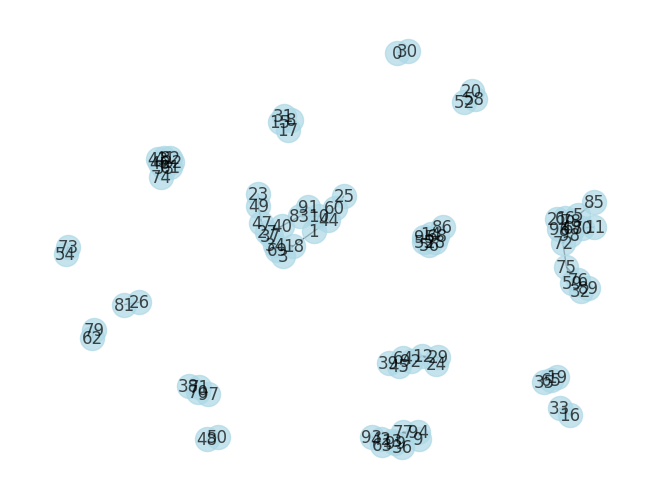

Number of nodes: 100, Number of edges: 304


In [52]:
class GraphInfo:
    def __init__(self, edges: tuple, num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes

sigma2 = 0.1
epsilon = 0.1


adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
G = nx.Graph()

for node, neighbor in zip(node_indices, neighbor_indices):
    G.add_edge(node, neighbor)

pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    edge_color='black',
    alpha=0.7
)
plt.show()

graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"Number of nodes: {graph.num_nodes}, Number of edges: {len(graph.edges[0])}")

In [53]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [54]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [57]:
in_feat = 1
batch_size = 64
epochs = 15
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - loss: 0.7115 - val_loss: 0.5802
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - loss: 0.4548 - val_loss: 0.3989
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - loss: 0.3132 - val_loss: 0.2768
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - loss: 0.2367 - val_loss: 0.2153
Epoch 5/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - loss: 0.1949 - val_loss: 0.1858
Epoch 6/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - loss: 0.1706 - val_loss: 0.1672
Epoch 7/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - loss: 0.1560 - val_loss: 0.1550
Epoch 8/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - loss: 0.1451 - val_loss: 0.1462
Epoch 9/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 0.1366 - val_loss: 0.1400
Epoch 10/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - loss: 0.1306 - val_loss: 0.1360
Epoch 11/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - loss: 0.1268 - val_loss: 0.1334
Epoch 12/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 15

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Model RMSE: 0.4394
Model MAPE: 0.3144
Model MAE: 0.236, Naive MAE: 0.240
naive MSE: 0.2013748157312925, model MSE: 0.19302897900314864


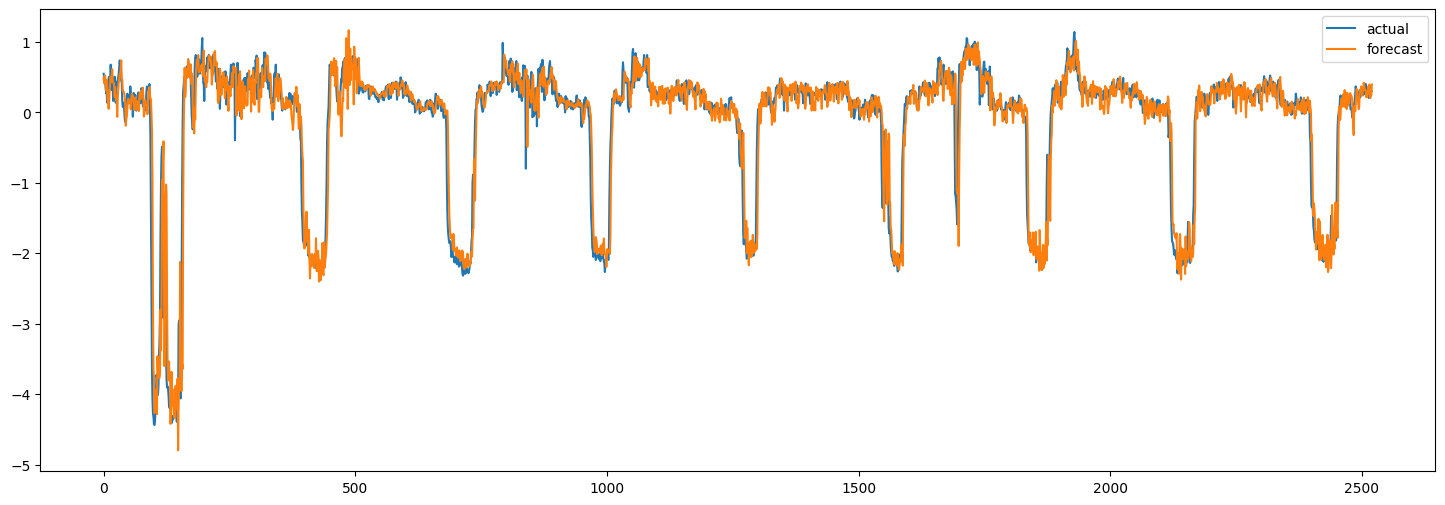

In [64]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(np.square(y_pred[:, 0, :] - y[:, 0, :])))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y[:, 0, :] - y_pred[:, 0, :])) / y[:, 0, :])

nmae = np.abs(x_test[:, -1, :, 0] - y[:, 0, :]).mean()

mae = np.mean(np.abs(y[:, 0, :] - y_pred[:, 0, :]))
# Print RMSE and MAPE
print(f"Model RMSE: {rmse:.4f}")
print(f"Model MAPE: {mape:.4f}")
print(f'Model MAE: {mae:.3f}, Naive MAE: {nmae:.3f}')
print(f"naive MSE: {naive_mse}, model MSE: {model_mse}")